<a href="https://colab.research.google.com/github/fquinterov/dfp-blender/blob/main/dfp_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from math import radians
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from skimage.measure import profile_line
from IPython import display
from time import sleep
import numpy as np
import scipy.linalg
import cv2

def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

def comp_distortion(xdc,k):
  k1 = k[0]
  k2 = k[1]
  k3 = k[2]
  p1 = k[3]
  p2 = k[4]

  x = xdc

  for kk in range(18):
    r_2 = np.sum(x*x,axis=0)
    k_radial = 1 + k1*r_2 + k2*r_2*r_2 + k3*r_2*r_2*r_2
    delta_x = 2*p1*x[0,:]*x[1,:] + p2*(r_2 + 2*x[0,:]*x[0,:])
    x = (xdc - delta_x)/(np.ones([2,1])*k_radial)

  return x

In [52]:
pitch=[1280,640,320,160,80,40,20]
plen=np.size(pitch)
wp=np.empty([plen,1024,1280,3])
ftype = '.png'

for i in range(plen):
    i1 = np.double(cv.imread('/content/fringe_' + str(pitch[i]) + '_1' + ftype))
    i2 = np.double(cv.imread('/content/fringe_' + str(pitch[i]) + '_2' + ftype))
    i3 = np.double(cv.imread('/content/fringe_' + str(pitch[i]) + '_3' + ftype))
    i4 = np.double(cv.imread('/content/fringe_' + str(pitch[i]) + '_4' + ftype))
    i5 = np.double(cv.imread('/content/fringe_' + str(pitch[i]) + '_5' + ftype))

    ICN = i1*np.cos(0)+i2*np.cos(2*np.pi/5)+i3*np.cos(4*np.pi/5)+i4*np.cos(6*np.pi/5)+i5*np.cos(8*np.pi/5)
    ISN = i1*np.sin(0)+i2*np.sin(2*np.pi/5)+i3*np.sin(4*np.pi/5)+i4*np.sin(6*np.pi/5)+i5*np.sin(8*np.pi/5)
    phase = -np.arctan2(ISN,ICN)
    
    cv.imwrite('./phase_' + str(pitch[i]) +  '.bmp',phase)
    wp[i] = phase

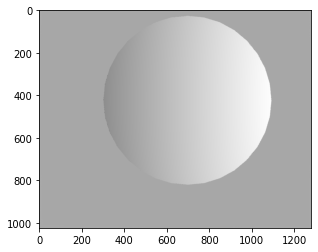

In [53]:
ap = wp[0]
for k in range(1,plen):
    deltap = wp[k] - wp[k - 1]
    ap = ap + deltap + 2*np.pi*(np.round_((ap - deltap)/(2*np.pi)))

plt.imshow(scale_range(ap.copy(), 0, 255)/255)
import scipy.io
scipy.io.savemat('phase.mat', {'phase': ap})

In [54]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from PIL import Image
from matplotlib import pyplot as plt

# camera intrinsic matrix
Kc = np.array([[2500,            0, 700],
               [   0,  2500, 1024-600],
               [   0,          0,     1]])

# projector intrinsic matrix
Kp = np.array([[1920,    0, 640],
               [   0, 1920, 512],
               [   0,    0,   1]])

# projector extrinsic matrix
Tp = np.array([[40, 0, 0]])
Rp = np.array([[0,  radians(0), radians(0)]])
Rp = R.from_rotvec(Rp)
Rp  = Rp.as_matrix()[0, :, :]
mp = np.concatenate((Rp, Tp.T), axis=1)

#-Rp.T@Tp.T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply


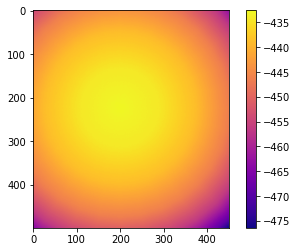

In [55]:
# read absolute phase
phase = ap[:,:,0]
phase = phase*20/(2*np.pi) +640

# mapping camera coordinates
cresx = 1280
cresy = 1024
x = np.linspace(1, cresx, cresx)
y = np.linspace(1, cresy, cresy)
uc, vc = np.meshgrid(x, y)
uc = uc.flatten()
vc = vc.flatten()

# mapping projector coordinates
up = phase.flatten()

# coordenadas normalizadas cámara [ucd, vcd, 1]'
xdc = np.linalg.inv(Kc)@np.array([uc, vc, np.ones(cresx*cresy)])
k = np.array([-0.171355, 0.486497, -3.598751, 0, 0])
xdc = comp_distortion(xdc[0:2,:],k)

# coordenadas normalizadas proyector [upd, upd, 1]'
xdp = np.linalg.inv(Kp)@np.array([up, up, np.ones(cresx*cresy)])
upd = xdp[0, :]

# triangulación
A =  mp[0, 0] - mp[2, 0]*upd;
B =  mp[0, 1] - mp[2, 1]*upd;
C =  mp[0, 2] - mp[2, 2]*upd;
D = -mp[0, 3] + mp[2, 3]*upd;

Zw = -D/(A*xdc[0,:] + B*xdc[1,:] + C)
Xw = Zw*xdc[0,:]
Yw = Zw*xdc[1,:]
Zw = np.resize(Zw,(1024,1280))
Xw = np.resize(Xw,(1024,1280))
Yw = np.resize(Yw,(1024,1280))

plt.imshow(Zw[200:700,500:950],cmap = 'plasma')
plt.colorbar()
plt.savefig('pose00_1.png')
plt.show()

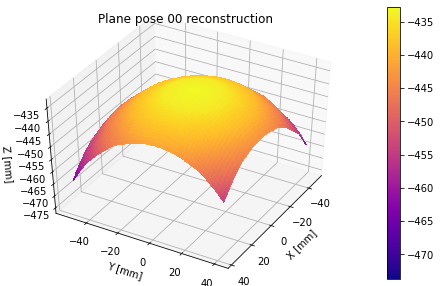

In [56]:
# Plot surface of the falt lapping specimen with roughtness profile
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(projection = '3d')


surf = ax.plot_surface(Xw[200:700,500:950],Yw[200:700,500:950],Zw[200:700,500:950], cmap = 'plasma', linewidth = 0, antialiased = False, alpha = 1)
fig.colorbar(surf)
ax.set_title('Plane pose 00 reconstruction')
ax.set_xlabel('X [mm]'); ax.set_ylabel('Y [mm]'); ax.set_zlabel('Z [mm]')
elev = 42.0; azim = 30; ax.view_init(elev, azim)
plt.savefig('pose00.png')
plt.show()


In [57]:
data = np.c_[ Xw[20:900,20:1000].flatten(), Yw[20:900,20:1000].flatten(), Zw[20:900,20:1000].flatten()]
A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
Zcoord = C[0]*Xw[20:900,20:1000] + C[1]*Yw[20:900,20:1000] + C[2]

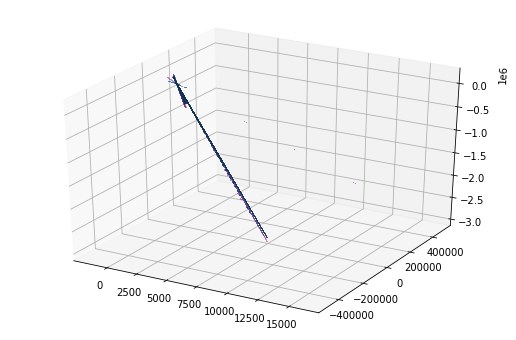

In [58]:
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(projection = '3d')

surf = ax.plot_surface(Xw[20:900,20:1000], Yw[20:900,20:1000], Zcoord, linewidth = 0, antialiased = False, alpha = 0.8)
surf = ax.plot_surface(Xw[20:900,20:1000], Yw[20:900,20:1000], Zw[20:900,20:1000], cmap = 'plasma', linewidth = 0, antialiased = False, alpha = 0.5)

In [25]:
Zw[20:900,20:1000]-Zcoord
ErrorRMS = np.sqrt(np.sum((Zw[20:900,20:1000]-Zcoord)**2))/(cresx*cresy)
ErrorRMS

4.9321129782850676e-05

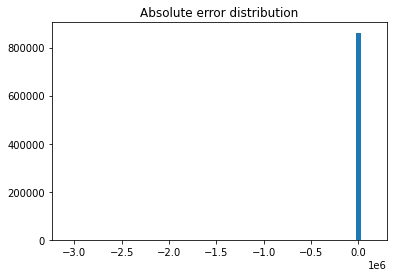

In [48]:
dif=(Zw[20:900,20:1000]-Zcoord)
plt.hist(dif.flatten(),bins = 60)
plt.title('Absolute error distribution')
plt.savefig('pose00_2.png')
plt.show()

In [ ]:
plt.savefig('pose00.png')dif

array([[-0.13962893, -0.12783138, -0.12350121, ...,  0.04259296,
         0.06486713, -0.0214538 ],
       [-0.08795356, -0.04084228, -0.11860678, ...,  0.05204306,
        -0.03051819, -0.08158312],
       [-0.08926622, -0.21105528, -0.0941073 , ..., -0.00322147,
        -0.08343668, -0.02908052],
       ...,
       [-0.01915757, -0.18937206, -0.05683701, ..., -0.00477521,
        -0.02988115, -0.15017836],
       [-0.07062844, -0.03303576, -0.1509959 , ..., -0.07969512,
        -0.13537165, -0.17846271],
       [-0.20700877,  0.00855121, -0.2525619 , ...,  0.00039734,
        -0.07861781, -0.12207138]])